# Libraries & Constants

In [1]:
import pandas as pd
from tqdm import tqdm
import json
import random
import spacy
import matplotlib.pyplot as plt
import crosslingual_coreference
import copy
from itertools import chain
from collections import Counter
from spacy import displacy
import spacy_annotator as spa

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MR\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
DATA_MINI_PATH   = "../data/processed/dataset3_mini.csv"
COREF_TEXT_PATH = "../data/processed/coref_text_data_mini.txt"
CORRECTED_NER_DATA_MINI_JSON_PATH = "../data/processed/json_datasets/corrected_train_data_mini.json"

TRAIN_PATH = "../data/processed/ner_for_training/spacy_train_mini.json"
DEV_PATH = "../data/processed/ner_for_training/spacy_dev_mini.json"
TEST_PATH = "../data/processed/ner_for_training/spacy_test_mini.json"

---

## spaCy "en_core_web_sm" Model<a class="anchor" id="one"></a>

In [3]:
# Load the English small model for NER
nlp = spacy.load('en_core_web_sm')
# Print pipeline components
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [4]:
# List of available tags in spaCy
tags_list = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW", "LOC", "MONEY", 
             "NORP", "ORDINAL", "ORG", "PERCENT", "PERSON", "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]

In [5]:
# Print explanation of each tag
for tag in tags_list:
    print(tag, ":   ", spacy.explain(tag))

CARDINAL :    Numerals that do not fall under another type
DATE :    Absolute or relative dates or periods
EVENT :    Named hurricanes, battles, wars, sports events, etc.
FAC :    Buildings, airports, highways, bridges, etc.
GPE :    Countries, cities, states
LANGUAGE :    Any named language
LAW :    Named documents made into laws.
LOC :    Non-GPE locations, mountain ranges, bodies of water
MONEY :    Monetary values, including unit
NORP :    Nationalities or religious or political groups
ORDINAL :    "first", "second", etc.
ORG :    Companies, agencies, institutions, etc.
PERCENT :    Percentage, including "%"
PERSON :    People, including fictional
PRODUCT :    Objects, vehicles, foods, etc. (not services)
QUANTITY :    Measurements, as of weight or distance
TIME :    Times smaller than a day
WORK_OF_ART :    Titles of books, songs, etc.


In [6]:
# Select specific tags
modified_tags_list = ["DATE", "EVENT", "FAC","LOC", "MONEY", "ORG"]

## Dataset Mini

In [7]:
#Read the dataset
dataset_mini = pd.read_csv(DATA_MINI_PATH)
dataset_mini

,City,Category,POI,Description,Country
0,Cairo,sleep,Le Passage,was Iberotel,Egypt
1,Cairo,see,Egyptian Museum,Located in the Midan Tahrir area and officiall...,Egypt
2,Cairo,see,Ibn Tulun,"Arguably the oldest mosque in Cairo, built bet...",Egypt
3,Cairo,see,Al-Azhar Park,A recently opened landscaped gardens overlooki...,Egypt
4,Cairo,see,Khan El Khalily,Cairo's souk area where visitors will find man...,Egypt
...,...,...,...,...,...
2930,Sharm el-Sheikh,sleep,Hyatt Regency Sharm El Sheikh,5 star resort style hotel with 439 rooms and s...,Egypt
2931,Sharm el-Sheikh,sleep,Noria Resort,It has been built in traditional Roman Style. ...,Egypt
2932,Sharm el-Sheikh,sleep,Ritz Carlton,"Spa, diving and snorkelling from the hotel.",Egypt
2933,Sharm el-Sheikh,sleep,The Cleopatra Luxury Resort Collection,"Spa, diving and snorkelling from the hotel.",Egypt


**The below function was used to create NER format for spaCy before manual entities correction. However, we replaced it with the " 
<a href="https://github.com/ieriii/spacy-annotator">spaCy Annotator</a>
" below that streamlines the process."**

In [8]:
#This function produces format for NER with spaCy
# def create_ner_train_data_mini(df):
#     """Create a modified training data where specific tags are selected & empty entities lists are dropped.
#     Args:
#       df (DataDrame): Dataset in a DataFrame format
#     Returns:
#         TRAINING_DATA: A list of tuples where a tuple contains description text & its tags
#      """
#     desc = df["Description"]
    
#     index_list = []
#     entities = []
#     ents_dict = {}
#     TRAINING_DATA = []
    
#     for i, d in tqdm(enumerate(desc)):
#         doc = nlp(d)
#         for ent in doc.ents:
#             if ent.label_ in modified_tags_list:
#                 entities.append([ent.start_char, ent.end_char, ent.label_])
#             else:
#                 continue
        
#         # Drop the row if no entities exist in the description
# #         if entities == []:
# #             continue
            
#         ents_dict["entities"] = entities
#         TRAINING_DATA.append((d, ents_dict.copy()))
#         index_list.append(i)
        
#         entities = []
    
#     return index_list, TRAINING_DATA

---

# Apply Coreference Resolution on Descriptions

In [9]:
#Create a copy of dataset_mini
coref_dataset_mini = dataset_mini.copy(deep=True)

**In the coref model below, we use the GPU by specifying "device": 0 in the config parameter.**

In [10]:
# Create coreference resolution model to modify the textual descriptions
coref = spacy.load('en_core_web_sm', disable=["tagger", "parser", "attribute_ruler", "lemmatizer", "ner"])
coref.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": 0})

2022-08-06 10:58:42,455 - INFO - allennlp.common.plugins - Plugin allennlp_models available
2022-08-06 10:58:42,463 - INFO - allennlp.models.archival - loading archive file models/crosslingual-coreference/minilm/model.tar.gz
2022-08-06 10:58:42,464 - INFO - allennlp.models.archival - extracting archive file models/crosslingual-coreference/minilm/model.tar.gz to temp dir C:\Users\MR\AppData\Local\Temp\tmp94x51mxn
2022-08-06 10:58:46,853 - WARNING - allennlp.common.params - error loading _jsonnet (this is expected on Windows), treating C:\Users\MR\AppData\Local\Temp\tmp94x51mxn\config.json as plain json
2022-08-06 10:58:46,855 - INFO - allennlp.common.params - dataset_reader.type = coref
2022-08-06 10:58:46,855 - INFO - allennlp.common.params - dataset_reader.max_instances = None
2022-08-06 10:58:46,857 - INFO - allennlp.common.params - dataset_reader.manual_distributed_sharding = False
2022-08-06 10:58:46,857 - INFO - allennlp.common.params - dataset_reader.manual_multiprocess_sharding 

2022-08-06 10:59:13,082 - INFO - allennlp.common.params - model.context_layer.type = pass_through
2022-08-06 10:59:13,083 - INFO - allennlp.common.params - model.context_layer.type = pass_through
2022-08-06 10:59:13,084 - INFO - allennlp.common.params - model.context_layer.input_dim = 384
2022-08-06 10:59:13,086 - INFO - allennlp.common.params - model.mention_feedforward.type = ref
2022-08-06 10:59:13,089 - INFO - allennlp.common.params - model.mention_feedforward.input_dim = 1172
2022-08-06 10:59:13,090 - INFO - allennlp.common.params - model.mention_feedforward.num_layers = 2
2022-08-06 10:59:13,091 - INFO - allennlp.common.params - model.mention_feedforward.hidden_dims = 1500
2022-08-06 10:59:13,093 - INFO - allennlp.common.params - model.mention_feedforward.activations = relu
2022-08-06 10:59:13,094 - INFO - allennlp.common.params - type = relu
2022-08-06 10:59:13,095 - INFO - allennlp.common.params - type = relu
2022-08-06 10:59:13,097 - INFO - allennlp.common.params - type = relu

2022-08-06 10:59:13,283 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.output.LayerNorm.weight
2022-08-06 10:59:13,284 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.output.dense.bias
2022-08-06 10:59:13,285 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.0.output.dense.weight
2022-08-06 10:59:13,285 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.1.attention.output.LayerNorm.bias
2022-08-06 10:59:13,286 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.1.attention.output.LayerNorm.weight
2022-08-06 10:59:13,287 - INFO - allennlp.nn.initializers -    _text_field_embedde

2022-08-06 10:59:13,322 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.intermediate.dense.bias
2022-08-06 10:59:13,323 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.intermediate.dense.weight
2022-08-06 10:59:13,327 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.output.LayerNorm.bias
2022-08-06 10:59:13,336 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.output.LayerNorm.weight
2022-08-06 10:59:13,337 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.11.output.dense.bias
2022-08-06 10:59:13,338 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_e

2022-08-06 10:59:13,372 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.4.attention.self.query.weight
2022-08-06 10:59:13,372 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.4.attention.self.value.bias
2022-08-06 10:59:13,373 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.4.attention.self.value.weight
2022-08-06 10:59:13,376 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.4.intermediate.dense.bias
2022-08-06 10:59:13,377 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.4.intermediate.dense.weight
2022-08-06 10:59:13,379 - INFO - allennlp.nn.initializers -    _text_field_emb

2022-08-06 10:59:13,409 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.7.attention.self.key.bias
2022-08-06 10:59:13,410 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.7.attention.self.key.weight
2022-08-06 10:59:13,411 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.7.attention.self.query.bias
2022-08-06 10:59:13,412 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.7.attention.self.query.weight
2022-08-06 10:59:13,416 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.encoder.layer.7.attention.self.value.bias
2022-08-06 10:59:13,417 - INFO - allennlp.nn.initializers -    _text_field_embed

2022-08-06 10:59:13,456 - INFO - allennlp.nn.initializers -    _text_field_embedder.token_embedder_tokens._matched_embedder.transformer_model.pooler.dense.weight
2022-08-06 10:59:13,907 - INFO - allennlp.modules.token_embedders.embedding - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2022-08-06 10:59:13,908 - INFO - allennlp.modules.token_embedders.embedding - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2022-08-06 10:59:15,767 - INFO - allennlp.models.archival - removing temporary unarchived model dir at C:\Users\MR\AppData\Local\Temp\tmp94x51mxn


In [12]:
doc = nlp(dataset_mini["Description"].iloc[107])
# options = {"ents": modified_tags_list}
# displacy.render(doc, style = "ent", options = options)
print(doc)

Built in 1794 by Ibrahim Katkhuda El-Sennari, a Sudanese occultist, Beit al-Sennari housed French artists and scholars after Napoleon arrived. The house was restored in 1995, and opened to the public in 2000. The house is home to the Institute for Applied Arts, which has glassware, pottery, and other works on display. You can also see the courtyard and open gardens, and the various sections of the house.


In [13]:
resolved_desc_list = []
for desc in tqdm(coref_dataset_mini["Description"]):
    #Crosslingual-coreference library throws an error when the length of text is < 3 words, so we overcome that error
    if len(desc.split()) <= 2:
        resolved_desc_list.append(desc)
        continue
    resolved_desc = coref(desc)._.resolved_text
    resolved_desc_list.append(resolved_desc)

100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [05:37<00:00,  8.71it/s]


In [14]:
coref_dataset_mini["Description"] = resolved_desc_list

In [15]:
doc2 = nlp(coref_dataset_mini["Description"].iloc[107])
# displacy.render(doc2, style = "ent", options = options)
print(doc2)

Built in 1794 by Ibrahim Katkhuda El-Sennari, a Sudanese occultist, Beit al-Sennari housed French artists and scholars after Napoleon arrived. Beit al-Sennari was restored in 1995, and opened to the public in 2000. Beit al-Sennari is home to the Institute for Applied Arts, which has glassware, pottery, and other works on display. You can also see the courtyard and open gardens, and the various sections of Beit al-Sennari.


**We can see from above after applying Co-reference Resolution that "Beit al-Sennari" was resolved 3 times from "the house".**

In [15]:
coref_dataset_mini

,City,Category,POI,Description,Country
0,Cairo,sleep,Le Passage,was Iberotel,Egypt
1,Cairo,see,Egyptian Museum,Located in the Midan Tahrir area and officiall...,Egypt
2,Cairo,see,Ibn Tulun,"Arguably the oldest mosque in Cairo, built bet...",Egypt
3,Cairo,see,Al-Azhar Park,A recently opened landscaped gardens overlooki...,Egypt
4,Cairo,see,Khan El Khalily,Cairo's souk area where visitors will find man...,Egypt
...,...,...,...,...,...
2930,Sharm el-Sheikh,sleep,Hyatt Regency Sharm El Sheikh,5 star resort style hotel with 439 rooms and s...,Egypt
2931,Sharm el-Sheikh,sleep,Noria Resort,It has been built in traditional Roman Style. ...,Egypt
2932,Sharm el-Sheikh,sleep,Ritz Carlton,"Spa, diving and snorkelling from the hotel.",Egypt
2933,Sharm el-Sheikh,sleep,The Cleopatra Luxury Resort Collection,"Spa, diving and snorkelling from the hotel.",Egypt


In [17]:
#Save the coreferenced text
#Saved once then commented out, to resave then uncomment & save

coref_dataset_mini.Description.to_csv(COREF_TEXT_PATH, sep=' ', index=False)

In [27]:
def tags_count(df):
    """Applies spaCy en_core_web_sm model on descriptions to extarct named entities tags.
    Args:
      df (DataDrame): Dataset in a DataFrame format
    Returns:
        all_tags: Extracted etags from the description text
     """
    
    desc = df["Description"]
    tags = []
    all_tags = []
    for d in tqdm(desc):
        doc = nlp(d)
        for ent in doc.ents:
            if ent.label_ in modified_tags_list:
                tags.append(ent.label_)
        all_tags.append(tags)
        tags = []
    
    return all_tags

In [28]:
#Count the tags in the mini dataset before manual correction
tags_before = tags_count(coref_dataset_mini)
#Get the total tags count
total_tags_count = sum([len(t) for t in tags_before])
print("Total tags count ->",total_tags_count)

100%|██████████████████████████████████████████████████████████████████████████████| 2935/2935 [00:36<00:00, 79.69it/s]

Total tags count -> 7913


In [29]:
#Get the count of each tag
single_tag_count_before = pd.Series(Counter(chain.from_iterable(tags_before)))
print(single_tag_count_before)

ORG      3383
LOC       890
FAC       869
DATE     2392
MONEY     274
EVENT     105
dtype: int64


Text(0.5, 1.0, 'Count of Entities Tags before Correction')

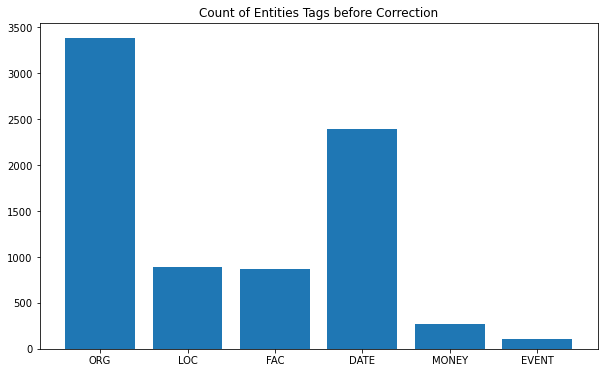

In [115]:
plt.figure(figsize=(10, 6))
plt.bar(single_tag_count_before.index,single_tag_count_before)
plt.title("Count of Entities Tags before Correction")
for i, v in enumerate(single_tag_count_before):
    plt.text(i-0.15, v+40, v, fontsize = "large")

---

# Initial Annotation  & Manual Entities Correction

**We will do the following steps:**
1. Initially annotate the descriptions using spaCy "en_core_web_sm" model.
2. Use spaCy Annotator library to correct the mis-annotated or missed entities.

In [38]:
annotator = spa.Annotator(labels=modified_tags_list, model=nlp)

In [39]:
annotator.instructions


            Instructions 

            For each entity type, input must be a DELIMITER separated string. 

            If no entities in text, leave as is and press submit.
            Similarly, if no entities for a particular label, leave as is. 

            Buttons: 

            	 * submit inserts new annotation (or overwrites existing one if one is present). 

            	 * skip moves forward and leaves empty string (or existing annotation if one is present). 

            	 * finish terminates the annotation session.
            


In [40]:
labelled_coref_df = annotator.annotate(df=coref_dataset_mini, col_text="Description", shuffle=False)

HTML(value='-1 examples annotated, 2936 examples left')

Text(value='', description='DATE', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='EVENT', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='FAC', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='LOC', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='MONEY', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='ORG', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Output()

In [55]:
labelled_coref_list = []
ents_dict = {}

for txt, annots in labelled_coref_df.annotations:
    
    ents_dict["document"] = txt
    ents_dict["annotation"] = annots["entities"]
    labelled_coref_list.append(ents_dict.copy())
    ents_dict = {}

In [88]:
#Save the manually corrected dataset in JSON fromat
#Saved once then commented out, to resave then uncomment & save

# with open(CORRECTED_NER_DATA_MINI_JSON_PATH, 'w') as json_file:
#     json.dump(labelled_coref_list, json_file)

---

## Comparison after Manual Correction

In [90]:
#Count the tags in the mini dataset after manual correction
with open(CORRECTED_NER_DATA_MINI_JSON_PATH, "r") as json_file:
    corrected_coref = json.load(json_file)

In [97]:
corrected_coref

[{'document': 'was Iberotel', 'annotation': [[4, 12, 'ORG']]},
 {'document': "Located in the Midan Tahrir area and officially named Museum of Egyptian Antiquities but known by all as the Egyptian Museum, it hosts the world's premier collection of ancient Egyptian artifacts.",
  'annotation': [[15, 27, 'FAC'], [54, 84, 'ORG'], [105, 124, 'ORG']]},
 {'document': 'Arguably the oldest mosque in Cairo, built between 868-884.',
  'annotation': []},
 {'document': 'A recently opened landscaped gardens overlooking the Citadel',
  'annotation': [[53, 60, 'ORG']]},
 {'document': "Cairo's souk area where visitors will find many merchants selling perfume, spices, Gold, Egyptian hand craft.",
  'annotation': []},
 {'document': 'Located about one Kilometer away from the Midan El-Tahrir a five minutes walk, home of the last king of Egypt the exiled king Farouk.',
  'annotation': [[18, 27, 'FAC'], [38, 57, 'FAC']]},
 {'document': 'It is about twenty minutes driving from Downtown.',
  'annotation': [[40

In [103]:
tags_after = []
for line in corrected_coref:
    for item in line["annotation"]:
        tags_after.append(item[2])

In [108]:
single_tag_count_after = pd.Series(tags_after).value_counts()

In [112]:
single_tag_count_after = single_tag_count_after.reindex(index = single_tag_count_before.index)
single_tag_count_after

ORG      3765
LOC       896
FAC      1142
DATE     2350
MONEY     280
EVENT     126
dtype: int64

In [113]:
print("Total tags count after ->",sum(single_tag_count_after))

Total tags count after -> 8559


Text(0.5, 1.0, 'Count of Entities Tags After Correction')

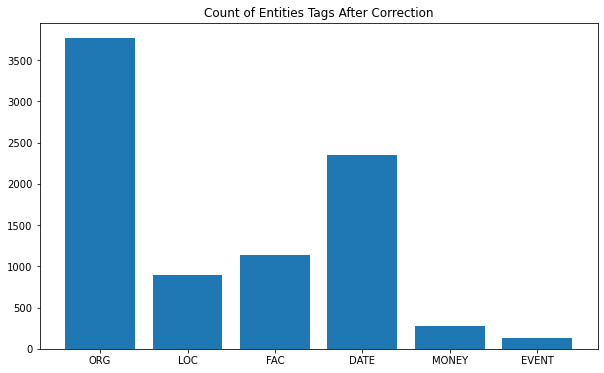

In [116]:
plt.figure(figsize=(10, 6))
plt.bar(single_tag_count_after.index,single_tag_count_after)
plt.title("Count of Entities Tags After Correction")
for i, v in enumerate(single_tag_count_after):
    plt.text(i-0.15, v+40, v, fontsize = "large")

---

## Save spaCy train, dev & test data.

In [117]:
train_mini = copy.deepcopy(corrected_coref)

In [118]:
random.shuffle(train_mini)

In [119]:
train_mini[:20]

[{'document': 'Great English beer, poor English food, friendly English staff. A unique atmosphere with reasonable prices, the Toad is an excellent place to get sloshed.',
  'annotation': []},
 {'document': "You can swim at Al Mamzar Beach or stroll in the park. Though less popular than other Dubai parks, the park has the park's share of Dubai's greenery.",
  'annotation': [[16, 31, 'LOC']]},
 {'document': 'The Virgil Avenue Tobacconist\'s slogan proudly declares it to be "where the city smokes", and if local renown is a measure of quality, that\'s hardly an exaggeration. This one-stop shop just off Hertel offers everything the the city smoking enthusiast could conceivably desire: imported cigarettes, pipes and pipe tobacco, rolling papers, loose cigarette tobacco, and — the main draw — a dizzying range of premium cigars shipped directly from factory to store. Ashton, Hemmingway, Arturo Fuentes, and Cohiba are only a few of the many brands to be found in Virgil Avenue\'s massive walk-in

In [120]:
#Save the train, dev & test datasets in JSON format
#Saved once then commented out, to resave then uncomment & save

# with open(TRAIN_PATH, 'w') as json_file:
#     json.dump(train_mini[:2000], json_file)

# with open(DEV_PATH, 'w') as json_file:
#     json.dump(train_mini[2000:2700], json_file)
    
# with open(TEST_PATH, 'w') as json_file:
#     json.dump(train_mini[2700:], json_file)

---